In [72]:
from openmmtools.testsystems import WaterCluster
testsystem = WaterCluster()

import numpy as np
import openmmtools
from openmmtools.constants import kB
from simtk import openmm as mm
from simtk.openmm import app
from tqdm import tqdm

# Versions helpful for debugging
print('openmmtools version: {}'.format(openmmtools.version.full_version))
print('openmm version: {}'.format(mm.version.full_version))

# Set some global variables
from simtk import unit
temperature = 298 * unit.kelvin
beta = 1.0 / (kB * temperature)

timestep = 2.0 * unit.femtosecond
temperature = 298 * unit.kelvin

integrator = openmmtools.integrators.BAOABIntegrator(
        measure_heat=False,
        measure_shadow_work=False,
        collision_rate=1.0 / unit.picoseconds,
        timestep=timestep,
        temperature=temperature,
    )

sim = app.Simulation(testsystem.topology, testsystem.system, integrator,
                 platform=mm.Platform.getPlatformByName("Reference"))

openmmtools version: 0.15.0
openmm version: 7.3.0.dev-5387707


In [73]:
sim.context.setPositions(testsystem.positions)
sim.context.setVelocitiesToTemperature(temperature)

In [74]:
%%time
sim.step(1)

CPU times: user 6.35 ms, sys: 1.32 ms, total: 7.67 ms
Wall time: 6.23 ms


In [75]:
%%time
sim.step(1)

CPU times: user 1.9 ms, sys: 878 µs, total: 2.78 ms
Wall time: 1.45 ms


In [76]:
sim.step(1000)

In [77]:
from tqdm import tqdm
samples = []
for _ in tqdm(range(100)):
    sim.step(1000)
    samples.append(sim.context.getState(getPositions=True).getPositions(asNumpy=True))

100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


In [78]:
samples[0].std(0), samples[-1].std(0)

(Quantity(value=array([0.246546648181693, 0.255607555877178, 0.25325697336242 ]), unit=nanometer),
 Quantity(value=array([0.374599732286267, 0.506091638308804, 0.200131265432709]), unit=nanometer))

In [79]:
sample_cache = samples

In [80]:
from openmmtools.alchemy import AlchemicalRegion, AbsoluteAlchemicalFactory
region = AlchemicalRegion(alchemical_atoms=range(3))
factory = AbsoluteAlchemicalFactory()
alchemical_system = factory.create_alchemical_system(testsystem.system, region)
testsystem.system = alchemical_system

In [81]:
timestep = 2 * unit.femtosecond
n_switching_steps = 3

integrator = openmmtools.integrators.AlchemicalNonequilibriumLangevinIntegrator(
    alchemical_functions={'lambda_electrostatics': '1-lambda',
                          'lambda_sterics': '1-lambda'
                         },
    splitting='V R O R V H',
    measure_heat=True,
    measure_shadow_work=False,
    nsteps_neq=n_switching_steps,
    collision_rate=1.0 / unit.picoseconds,
    timestep=timestep,
    temperature=temperature,
)

alch_sim = app.Simulation(testsystem.topology, testsystem.system, integrator,
                     platform=mm.Platform.getPlatformByName("Reference"))

alch_sim.context.setPositions(testsystem.positions)
alch_sim.context.setVelocitiesToTemperature(temperature)

In [82]:
parameter_names = list(alch_sim.context.getParameters())[:2]

In [83]:
for i in range(5):
    print('step: ', i)
    for name in parameter_names:
        print(name, alch_sim.context.getParameter(name))
    
    alch_sim.step(1)
    print()

step:  0
lambda_electrostatics 1.0
lambda_sterics 1.0

step:  1
lambda_electrostatics 0.6666666666666667
lambda_sterics 0.6666666666666667

step:  2
lambda_electrostatics 0.33333333333333337
lambda_sterics 0.33333333333333337

step:  3
lambda_electrostatics 0.0
lambda_sterics 0.0

step:  4
lambda_electrostatics 0.0
lambda_sterics 0.0



In [84]:
alch_sim.integrator.reset()

for name in parameter_names:
    print(name, alch_sim.context.getParameter(name))

lambda_electrostatics 0.0
lambda_sterics 0.0


In [85]:
alch_sim.integrator.setGlobalVariableByName('lambda', 0)
alch_sim.integrator.setGlobalVariableByName('lambda_step', 0)

for name in parameter_names:
    print(name, alch_sim.context.getParameter(name))

lambda_electrostatics 0.0
lambda_sterics 0.0


In [86]:
for i in range(5):
    print('step: ', i)
    for name in parameter_names:
        print(name, alch_sim.context.getParameter(name))
    
    alch_sim.step(1)
    print()

step:  0
lambda_electrostatics 0.0
lambda_sterics 0.0

step:  1
lambda_electrostatics 0.6666666666666667
lambda_sterics 0.6666666666666667

step:  2
lambda_electrostatics 0.33333333333333337
lambda_sterics 0.33333333333333337

step:  3
lambda_electrostatics 0.0
lambda_sterics 0.0

step:  4
lambda_electrostatics 0.0
lambda_sterics 0.0



In [87]:
alch_sim.integrator.reset()
alch_sim.integrator.setGlobalVariableByName('lambda', 0)
alch_sim.integrator.setGlobalVariableByName('lambda_step', 0)
alch_sim.context.setParameter('lambda_electrostatics', 1.0)
alch_sim.context.setParameter('lambda_sterics', 1.0)

for i in range(5):
    print('step: ', i)
    for name in parameter_names:
        print(name, alch_sim.context.getParameter(name))
    
    alch_sim.step(1)
    print()

step:  0
lambda_electrostatics 1.0
lambda_sterics 1.0

step:  1
lambda_electrostatics 0.6666666666666667
lambda_sterics 0.6666666666666667

step:  2
lambda_electrostatics 0.33333333333333337
lambda_sterics 0.33333333333333337

step:  3
lambda_electrostatics 0.0
lambda_sterics 0.0

step:  4
lambda_electrostatics 0.0
lambda_sterics 0.0



```
The context parameters created are:
 |  - softcore_alpha: factor controlling softcore lengthscale for Lennard-Jones
 |  - softcore_beta: factor controlling softcore lengthscale for Coulomb
 |  - softcore_a: softcore Lennard-Jones parameter from Eq. 13 of Ref [1]
 |  - softcore_b: softcore Lennard-Jones parameter from Eq. 13 of Ref [1]
 |  - softcore_c: softcore Lennard-Jones parameter from Eq. 13 of Ref [1]
 |  - softcore_d: softcore electrostatics parameter
 |  - softcore_e: softcore electrostatics parameter
 |  - softcore_f: softcore electrostatics parameter```

In [88]:
#n_samples = 1000
n_samples = 100

## Use pre-generated samples from the 298K ensemble with HBonds constrained
#import mdtraj as md
#samples = md.load('water_cluster_constrained_samples.h5')
#sample_cache = samples.xyz * unit.nanometer

# Define what will be variable during the experiments
splittings = {'VVVR (OVR-H-RVO)': 'O V R H R V O',
              'BAOAB-mid (VRO-H-RV)': 'V R O H R V',
              'BAOAB-end (VRORV-H)': 'V R O R V H',
              # 'velocity-verlet-mid (VR-H-RV)': 'V R H R V', # requires to disable LangevinIntegrator splitting checks
              # 'velocity-verlet-end (VRV-H)': 'V R V H', # requires to disable LangevinIntegrator splitting checks
              }


from collections import namedtuple
Condition = namedtuple('Condition', ['timestep', 'switching_time', 'n_switching_steps', 'splitting'])

def collect_samples_at_condition(condition):
    print(condition)

    timestep = condition.timestep
    n_switching_steps = condition.n_switching_steps
    splitting = splittings[condition.splitting]

    integrator = openmmtools.integrators.AlchemicalNonequilibriumLangevinIntegrator(
        alchemical_functions={'lambda_electrostatics': '1-lambda',
                              'lambda_sterics': '1-lambda'
                             },
        splitting=splitting,
        measure_heat=True,
        measure_shadow_work=False,
        nsteps_neq=n_switching_steps,
        collision_rate=1.0 / unit.picoseconds,
        timestep=timestep,
        temperature=temperature,
    )

    sim = app.Simulation(testsystem.topology, testsystem.system, integrator,
                         platform=mm.Platform.getPlatformByName("Reference"))

    # store in reduced units...
    w_shads = np.zeros(n_samples)
    w_prots = np.zeros(n_samples)
    w_tots = np.zeros(n_samples)
    reduced_DeltaEs = np.zeros(n_samples)

    for i in tqdm(range(n_samples + 1)):
        if i >= 1: i -= 1 # discard first sample

        # set initial (x,v) from equilibrium
        x0 = sample_cache[np.random.randint(len(sample_cache))]
        sim.context.setPositions(x0)
        sim.context.setVelocitiesToTemperature(temperature)

        # reset the relevant integrator state
        sim.integrator.reset()
        sim.integrator.setGlobalVariableByName('lambda', 0)
        sim.integrator.setGlobalVariableByName('lambda_step', 0)
        sim.context.setParameter('lambda_electrostatics', 1.0)
        sim.context.setParameter('lambda_sterics', 1.0)


        # get the total energy before switching
        state_0 = sim.context.getState(getEnergy=True)
        E_0 = state_0.getPotentialEnergy() + state_0.getKineticEnergy()

        # perform switching
        sim.step(n_switching_steps)

        # get the total energy change
        state_1 = sim.context.getState(getEnergy=True)
        E_1 = state_1.getPotentialEnergy() + state_1.getKineticEnergy()
        DeltaE = (E_1 - E_0)
        reduced_DeltaEs[i] = beta * DeltaE

        # get the heat and protocol work, derive total work, shadow work
        W_prot = integrator.get_protocol_work()
        w_prots[i] = beta * W_prot

        Q = integrator.get_heat()

        w_tots[i] = beta * (DeltaE - Q + W_prot)
        w_shads[i] = w_tots[i] - w_prots[i]

    result = {'w_shads': w_shads,
              'w_tots': w_tots,
              'w_prots': w_prots,
              'reduced_DeltaEs': reduced_DeltaEs
              }
    return result


def save_result(experiment_id, condition, result):
    from pickle import dump
    fname = str(experiment_id) + '.pkl'
    with open(fname, 'wb') as f:
        dump({'condition': condition, 'result': result}, f)

In [89]:
switching_time = 1.0 * unit.picosecond
timesteps = np.array([0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]) * unit.femtosecond
conditions = []
for timestep in timesteps:
    n_switching_steps = int(switching_time / timestep)

    condition = Condition(timestep=timestep,
                    switching_time=switching_time,
                    n_switching_steps=n_switching_steps,
                    splitting='BAOAB-end (VRORV-H)')
    print(condition)
    conditions.append(condition)

Condition(timestep=Quantity(value=0.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=2000, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=1000, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=1.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=666, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=2.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=500, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=2.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=400, splitting='BAOAB-end (VRORV-H)')
Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=333, splitting='BAOAB-end (VRORV-H

In [91]:
condition.splitting, splittings[condition.splitting]

('BAOAB-end (VRORV-H)', 'V R O R V H')

In [92]:
results = []
for experiment_id, condition in enumerate(conditions[::-1]):
    result = collect_samples_at_condition(condition)
    results.append(result)
    save_result(experiment_id=experiment_id, condition=condition, result=result)
results = results[::-1]

  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=4.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=250, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=3.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=285, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=333, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=2.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=400, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=2.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=500, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=1.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=666, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=1000, splitting='BAOAB-end (VRORV-H)')


  0%|          | 0/101 [00:00<?, ?it/s]

Condition(timestep=Quantity(value=0.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=2000, splitting='BAOAB-end (VRORV-H)')


100%|██████████| 101/101 [30:06<00:00, 17.89s/it]


In [93]:
result.keys()

dict_keys(['w_shads', 'w_tots', 'w_prots', 'reduced_DeltaEs'])

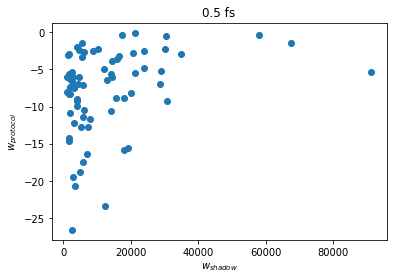

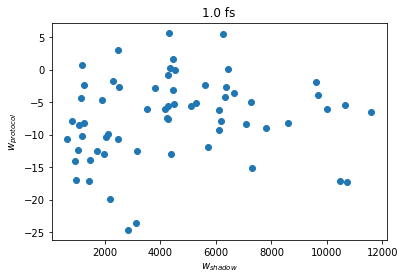

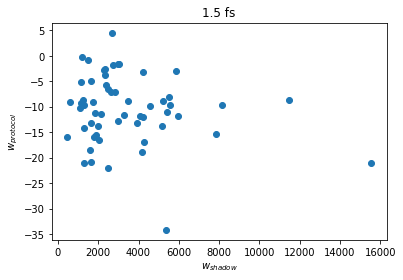

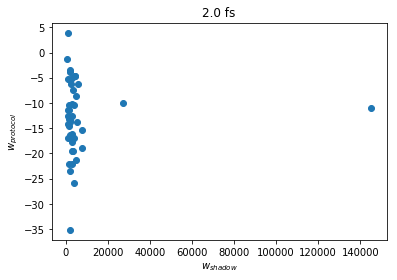

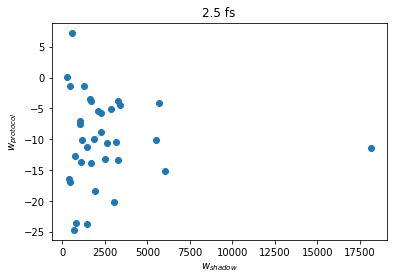

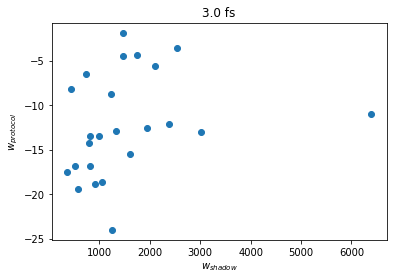

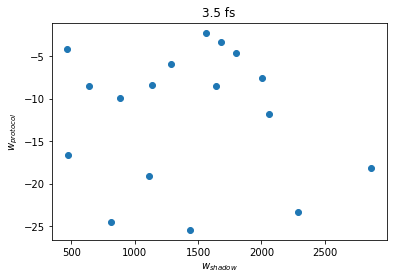

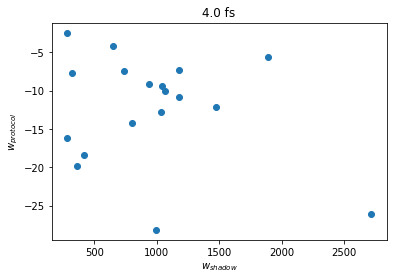

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, result in enumerate(results):
    plt.figure()
    plt.title(timesteps[i])
    plt.scatter(result['w_shads'][1:], result['w_prots'][1:])
    plt.xlabel(r'$w_{shadow}$')
    plt.ylabel(r'$w_{protocol}$')

In [95]:
for i, result in enumerate(results):
    print(conditions[i])
    print('\t# NaNs: ' + str(int(np.sum(np.isnan(result['w_shads'])))) + '\n')

Condition(timestep=Quantity(value=0.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=2000, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 26

Condition(timestep=Quantity(value=1.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=1000, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 35

Condition(timestep=Quantity(value=1.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=666, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 43

Condition(timestep=Quantity(value=2.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=500, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 57

Condition(timestep=Quantity(value=2.5, unit=femtosecond), switching_time=Quantity(value=1.0, unit=picosecond), n_switching_steps=400, splitting='BAOAB-end (VRORV-H)')
	# NaNs: 65

Condition(timestep=Quantity(value=3.0, unit=femtosecond), switching_time=Quantity(value=1.0, unit=

In [96]:
from pymbar import EXP

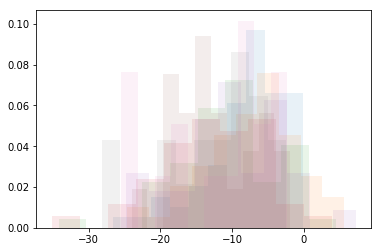

In [97]:
for result in results:
    okay_inds = np.isfinite(result['w_prots'])
    plt.hist(result['w_prots'][okay_inds], histtype='stepfilled', alpha=0.1, normed=True)

In [98]:
means = []
stddevs = []

EXP_estimates = []
EXP_uncs = []
for result in results:
    okay_inds = np.isfinite(result['w_prots'])
    means.append(result['w_prots'][okay_inds].mean())
    stddevs.append(np.std(result['w_prots'][okay_inds]))
    
    EXP_estimate, EXP_unc = EXP(result['w_prots'][okay_inds])
    EXP_estimates.append(EXP_estimate)
    EXP_uncs.append(EXP_unc)

(0, 7.606288796748227)

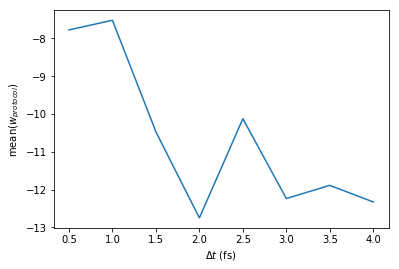

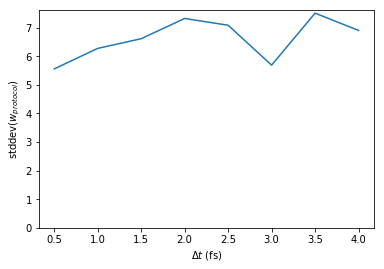

In [99]:
unitless_timesteps = timesteps / unit.femtoseconds
plt.plot(unitless_timesteps, means)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'mean($w_{protocol}$)')

plt.figure()
plt.plot(unitless_timesteps, stddevs)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'stddev($w_{protocol}$)')
plt.ylim(0,)

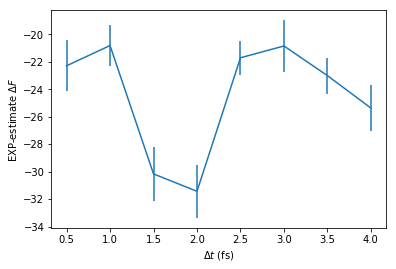

In [100]:
plt.errorbar(unitless_timesteps, EXP_estimates, 1.96 * np.array(EXP_uncs))
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'EXP-estimate $\Delta F$')

(0, 22805.13459709263)

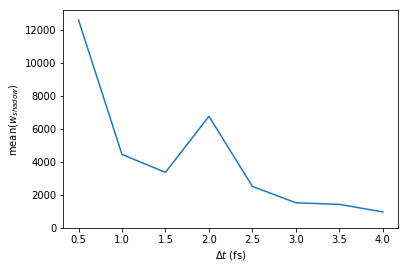

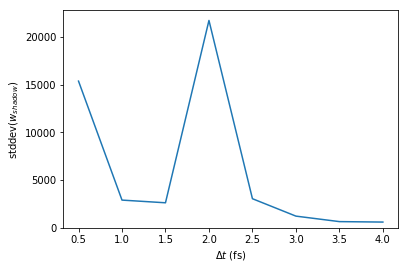

In [101]:
means = []
stddevs = []

for result in results:
    okay_inds = np.isfinite(result['w_shads'])
    means.append(result['w_shads'][okay_inds].mean())
    stddevs.append(np.std(result['w_shads'][okay_inds]))
    
unitless_timesteps = timesteps / unit.femtoseconds
plt.plot(unitless_timesteps, means)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'mean($w_{shadow}$)')
plt.ylim(0,)

plt.figure()
plt.plot(unitless_timesteps, stddevs)
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'stddev($w_{shadow}$)')
plt.ylim(0,)

In [108]:
EXP_estimates = []
EXP_uncs = []

n_bootstrap_samples = 10000
for result in results:
    okay_inds = np.isfinite(result['w_prots'])
    
    EXP_estimate = EXP(result['w_prots'][okay_inds], compute_uncertainty=False)
    EXP_estimates.append(EXP_estimate)
    
    
    okay_w_prots = result['w_prots'][okay_inds]
    bootstrap_samples = []
    for _ in range(n_bootstrap_samples):
        inds = np.random.randint(0, len(okay_w_prots), len(okay_w_prots))
        bootstrap_samples.append(EXP(okay_w_prots[inds], compute_uncertainty=False))
    
    EXP_uncs.append(np.std(bootstrap_samples))

In [109]:
EXP_uncs

[2.293820194888452,
 1.8689493451994186,
 5.793452558630408,
 4.964430522176831,
 1.256821504557181,
 2.0764524180900885,
 1.4321832521900186,
 2.880080688922247]

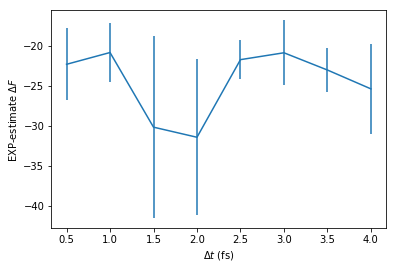

In [110]:
plt.errorbar(unitless_timesteps, EXP_estimates, 1.96 * np.array(EXP_uncs))
plt.xlabel(r'$\Delta t$ (fs)')
plt.ylabel(r'EXP-estimate $\Delta F$')

In [111]:
from openmmtools.alchemy import AlchemicalRegion, AbsoluteAlchemicalFactory
region = AlchemicalRegion(alchemical_atoms=range(3))
factory = AbsoluteAlchemicalFactory()
alchemical_system = factory.create_alchemical_system(testsystem.system, region)
testsystem.system = alchemical_system

integrator = openmmtools.integrators.BAOABIntegrator(
        measure_heat=False,
        measure_shadow_work=False,
        collision_rate=1.0 / unit.picoseconds,
        timestep=timestep,
        temperature=temperature,
    )
sim = app.Simulation(testsystem.topology, testsystem.system, integrator,
                 platform=mm.Platform.getPlatformByName("Reference"))

In [112]:
context_parameters = sim.context.getParameters()

In [113]:
context_parameters.asdict()

{'lambda_electrostatics': 1.0,
 'lambda_sterics': 1.0,
 'softcore_a': 1.0,
 'softcore_alpha': 0.5,
 'softcore_b': 1.0,
 'softcore_beta': 0.0,
 'softcore_c': 6.0,
 'softcore_d': 1.0,
 'softcore_e': 1.0,
 'softcore_f': 2.0}

In [114]:
kT = kB * temperature
kT

Quantity(value=2477.7127964236247, unit=joule/mole)

In [115]:
# what does instantaneous perturbation give us?

u_As = []
u_Bs = []
for sample in tqdm(sample_cache):
    sim.context.setPositions(sample)
    
    # evalutate at lambda = 1
    sim.context.setParameter('lambda_electrostatics', 1.0)
    sim.context.setParameter('lambda_sterics', 1.0)
    u_A = sim.context.getState(getEnergy=True).getPotentialEnergy() / kT
    u_As.append(u_A)
    
    # evaluate at lambda = 0
    sim.context.setParameter('lambda_electrostatics', 0.0)
    sim.context.setParameter('lambda_sterics', 0.0)
    u_B = sim.context.getState(getEnergy=True).getPotentialEnergy() / kT
    u_Bs.append(u_B)

100%|██████████| 100/100 [00:01<00:00, 61.59it/s]


In [116]:
# that... is very slow...

In [117]:
u_As = np.array(u_As)
u_Bs = np.array(u_Bs)

In [118]:
instantaneous_estimates = np.zeros(1000000)
for i in tqdm(range(len(instantaneous_estimates))):
    inds = np.random.randint(0, len(u_As), len(u_As))
    instantaneous_estimates[i] = np.log(np.mean(np.exp(u_As[inds] - u_Bs[inds])))

100%|██████████| 1000000/1000000 [00:19<00:00, 50978.58it/s]


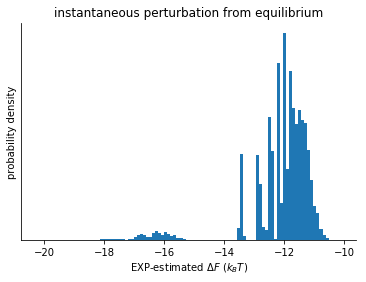

In [119]:
ax = plt.subplot(1,1,1)
plt.hist(instantaneous_estimates, bins=100, normed=True);
plt.yticks([])
plt.ylabel('probability density')
plt.xlabel(r'EXP-estimated $\Delta F$ ($k_B T$)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('instantaneous perturbation from equilibrium')
plt.savefig('bootstrapped.jpg', dpi=300)

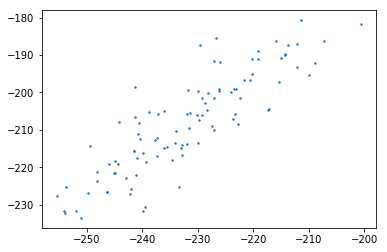

In [120]:
plt.scatter(u_As, u_Bs, s=2)